In [1]:
%run ../__init__.py
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Dataset annotations

In [2]:
# from source.datasets.megadepth.preprocessing.annotations import import create_dataset_annotations

# dataset_root = "/mnt/sda/datasets/MegaDepth"
# scene_info_root = "/mnt/sda/datasets/MegaDepth/SceneInfo"

# create_dataset_annotations(dataset_root, scene_info_root)

## DISK train set annotations

In [3]:
# from source.datasets.megadepth.preprocessing.annotations import create_train_pairs_disk

# scene_info_root = "/mnt/sda/datasets/MegaDepth/SceneInfo"

# create_train_pairs_disk(scene_info_root)

In [4]:
# from source.datasets.base.utils import from_pairs_annotations_csv

# from_pairs_annotations_csv(scene_info_root, 'train_disk_pairs.csv', 'train_disk.csv')

## Test set annotations

In [9]:
# ann_path = "/mnt/sda/datasets/MegaDepth/SceneInfo/annotations.csv"

# ann = pd.read_csv(ann_path, index_col=[0])

In [7]:
# city_panorama = [0, 2, 11, 47, 50, 103, 105, 143, 177, 265, 366, 860]
# buildings = [3, 22, 25, 26, 33, 94, 129, 175, 178, 294, 412, 430, 5013, 5014, 5015, 5016, 5017, 16, 121, 443]
# indoors = [20, 176, 204, 223, 474]
# statues = [107, 168, 229, 349, 768, 5018]
# wild = [1001, 4541]

# test = city_panorama + buildings + indoors + statues + wild

In [8]:
# num_samples = 300

# count_mask = ann[ann['scene_name'].isin(test)].groupby(du.SCENE_NAME).count()[du.IMAGE1] > num_samples

In [9]:
# from source.datasets.megadepth.preprocessing.annotations import create_prefix_pairs

# scene_info_root = "/mnt/sda/datasets/MegaDepth/SceneInfo"

# create_prefix_pairs(scene_info_root, 'test', list(count_mask[count_mask].index), num_samples)

In [10]:
# from source.datasets.base.utils import from_pairs_annotations_csv

# from_pairs_annotations_csv(scene_info_root, 'test_pairs.csv', 'test.csv')

## Pairs

In [11]:
from omegaconf import OmegaConf

from source.datasets.megadepth.transforms import get_megadepth_transforms
from source.datasets.megadepth.dataset import MegaDepthDataset
from torch.utils.data.dataloader import DataLoader

s = """
    csv_path: "/mnt/sda/datasets/MegaDepth/SceneInfo/train_disk_pairs.csv"
    data_options:
      - 'image'
      - 'depth'
      - 'calib'

    transforms:
      base: 'train'
      
      grayscale:
      
      resize:      
        width: -1
        height: -1
        
      crop1:
        type: 'divisor_crop'
        
      crop2:
        type: 'depth_crop'
"""

dataset_config = OmegaConf.create(s)

item_transforms = get_megadepth_transforms(dataset_config, 16)
dataset = MegaDepthDataset.from_config(dataset_config, 'f_pydegensac/2k', item_transforms)
loader = DataLoader(dataset, 1)

_iter = loader.__iter__()

In [12]:
item = next(_iter)

image1_name = item[du.IMAGE_NAME1]
image2_name = item[du.IMAGE_NAME2]

image1 = item[du.IMAGE1]
image2 = item[du.IMAGE2]

depth1 = item[du.DEPTH1]
depth2 = item[du.DEPTH2]

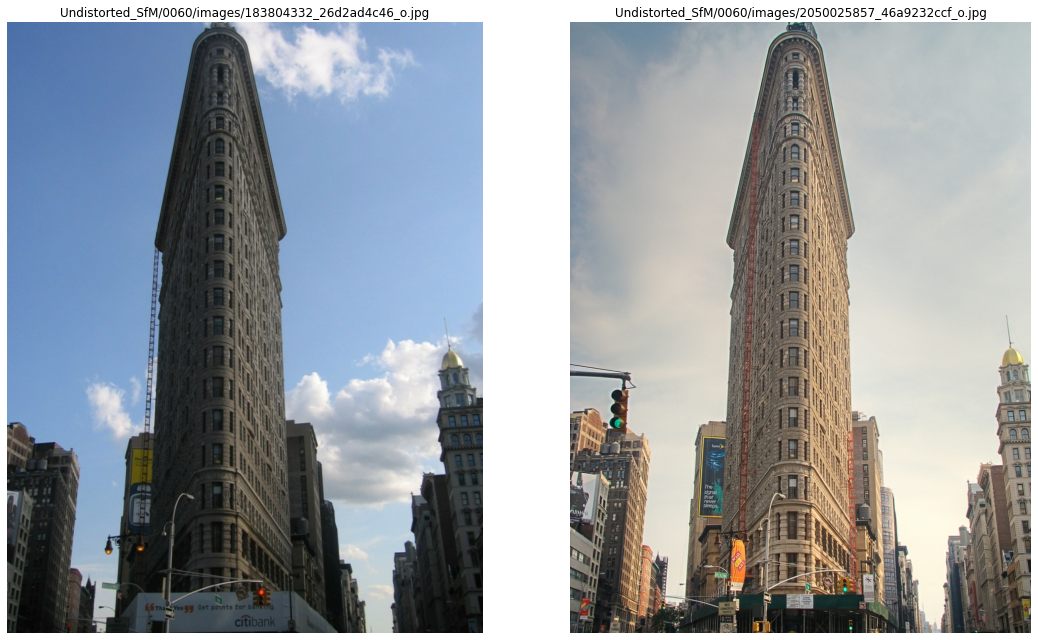

In [13]:
plot_figures({image1_name[0]: torch2cv(image1[0]), 
              image2_name[0]: torch2cv(image2[0])}, 1, 2, (16, 9))

In [14]:
from source.datasets.base.utils import RBTDataWrapper

rbt_data = RBTDataWrapper().init_from_batch(item, torch.device('cpu'))

In [15]:
from source.projective.rbt import warp_image_rbt

w_image2, vis_mask1 = warp_image_rbt(image2, rbt_data.swap(), 'im')
w_image1, vis_mask2 = warp_image_rbt(image1, rbt_data, 'im')

/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [16]:
idx = 0

cv_image1 = torch2cv(image1[idx])
cv_image2 = torch2cv(image2[idx])

cv_depth1 = torch2cv(depth1[idx], normalize=True, to_rgb=True)
cv_depth2 = torch2cv(depth2[idx], normalize=True, to_rgb=True)

cv_w_image1 = torch2cv(w_image1[idx])
cv_w_image2 = torch2cv(w_image2[idx])

cv_vis_mask1 = torch2cv(vis_mask1.float()[idx], to_rgb=True)
cv_vis_mask2 = torch2cv(vis_mask2.float()[idx], to_rgb=True)

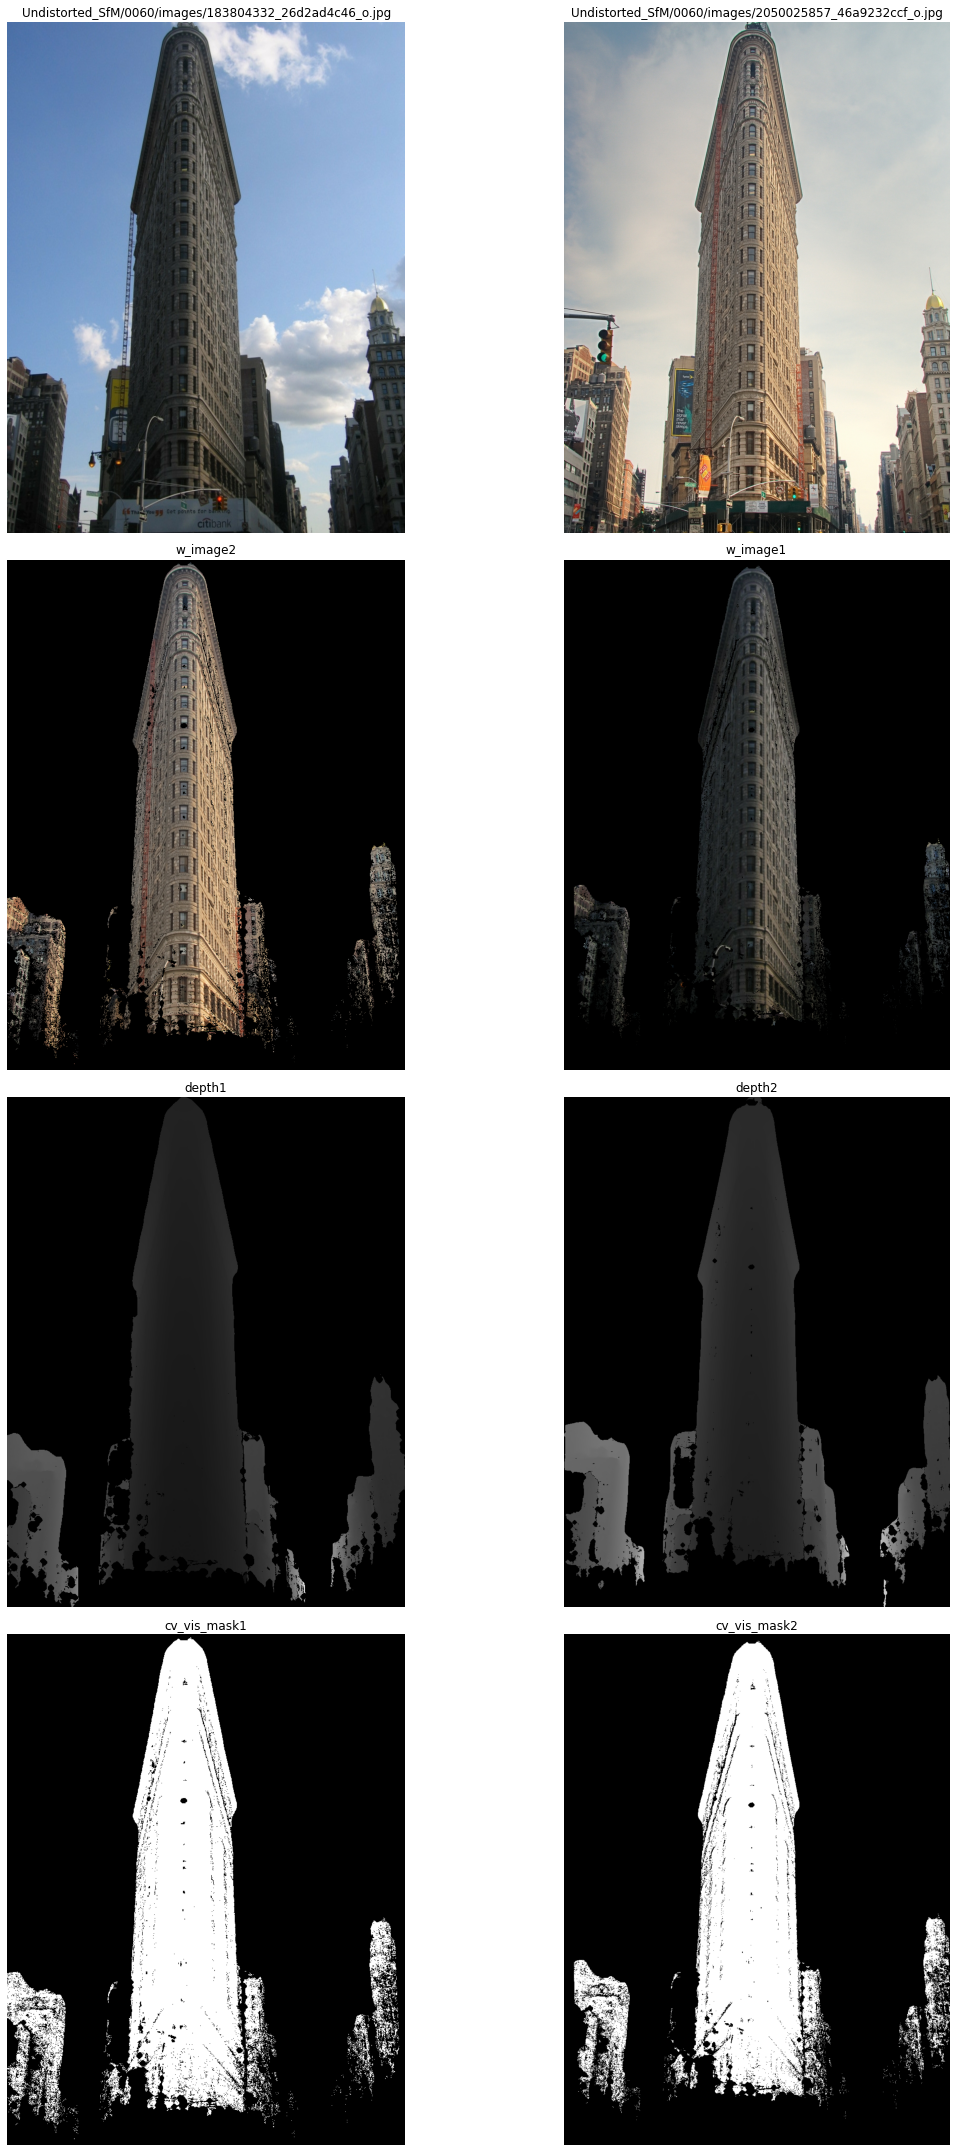

In [17]:
plot_figures({image1_name[idx]: cv_image1, image2_name[idx]: cv_image2,
              'w_image2': cv_w_image2, 'w_image1': cv_w_image1, 
              'depth1': cv_depth1, 'depth2': cv_depth2,
              'cv_vis_mask1': cv_vis_mask1, 'cv_vis_mask2': cv_vis_mask2}, 4, 2, (18, 30))

## Standalone

In [18]:
from omegaconf import OmegaConf
from source.datasets.megadepth.transforms import get_megadepth_transforms
from source.datasets.megadepth.dataset import MegaDepthDataset
from torch.utils.data.dataloader import DataLoader

s = """
    csv_path: "/mnt/sda/datasets/MegaDepth/SceneInfo/train_disk.csv"
    data_options:
      - 'image'
      - 'depth'

    transforms:
      base: 'train'
      
      grayscale:
      
      resize:      
        width: -1
        height: -1
        
      crop1:
        type: 'divisor_crop'
        
      crop2:
        type: 'depth_crop'
"""

dataset_config = OmegaConf.create(s)

item_transforms = get_megadepth_transforms(dataset_config, 16)
dataset = MegaDepthDataset.from_config(dataset_config, 'f_pydegensac/2k', item_transforms)
loader = DataLoader(dataset, 1)

_iter = loader.__iter__()

In [19]:
item = next(_iter)

image1_name = item[du.IMAGE_NAME1]

image1 = item[du.IMAGE1]

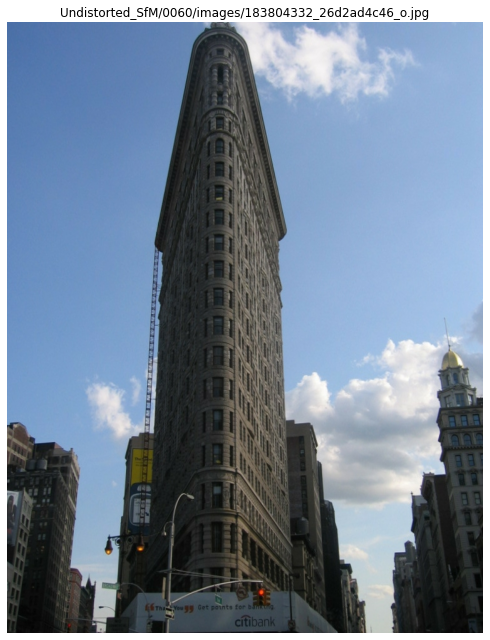

In [20]:
plot_figures({image1_name[0]: torch2cv(image1[0])}, 1, 1, (9, 9))

## Correspondences at different scales

In [21]:
from omegaconf import OmegaConf

from source.datasets.megadepth.transforms import get_megadepth_transforms
from source.datasets.megadepth.dataset import MegaDepthDataset
from torch.utils.data.dataloader import DataLoader

s = """
    csv_path: "/mnt/sda/datasets/MegaDepth/SceneInfo/train_disk_pairs.csv"
    data_options:
      - 'image'
      - 'depth'
      - 'calib'

    transforms:
      base: 'train'
      
      grayscale:
      
      resize:      
        width: -1
        height: -1
        
      crop1:
        type: 'divisor_crop'
        
      crop2:
        type: 'depth_crop'
"""

dataset_config = OmegaConf.create(s)

item_transforms = get_megadepth_transforms(dataset_config, 16)
dataset = MegaDepthDataset.from_config(dataset_config, 'f_pydegensac/2k', item_transforms)
loader = DataLoader(dataset, 1)

_iter = loader.__iter__()

In [22]:
item = next(_iter)

image1_name = item[du.IMAGE_NAME1]
image2_name = item[du.IMAGE_NAME2]

image1 = item[du.IMAGE1]
image2 = item[du.IMAGE2]

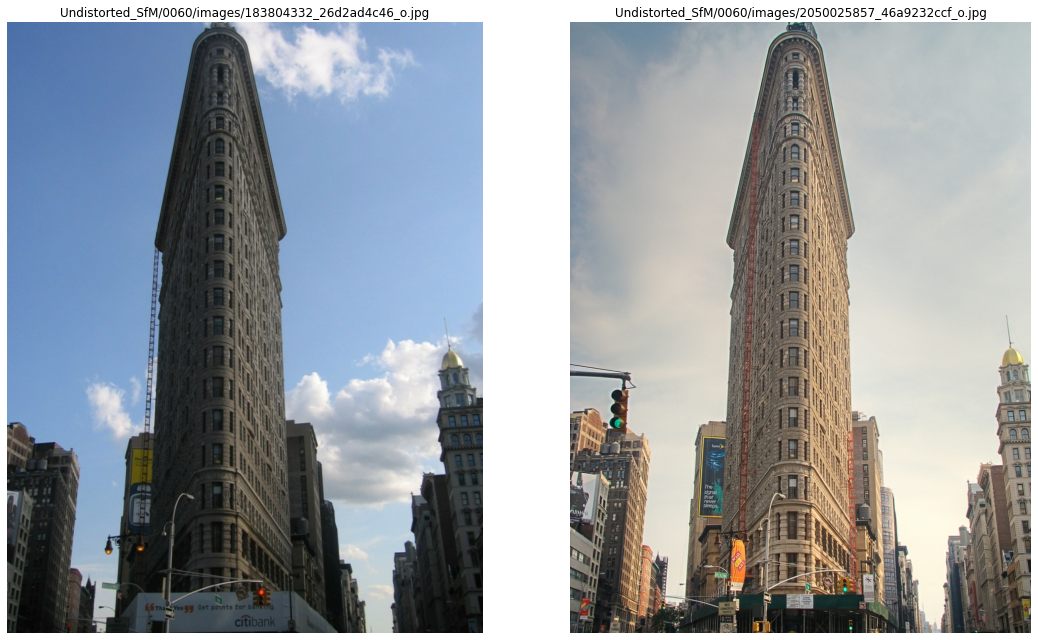

In [23]:
plot_figures({image1_name[0]: torch2cv(image1[0]), 
              image2_name[0]: torch2cv(image2[0])}, 1, 2, (16, 9))

In [24]:
from source.datasets.base.utils import RBTDataWrapper

rbt_data = RBTDataWrapper().init_from_batch(item, torch.device('cpu'))

/home/konstantin/personal/Summertime/source/utils/endpoint_utils.py:375: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y = flat_ids // w


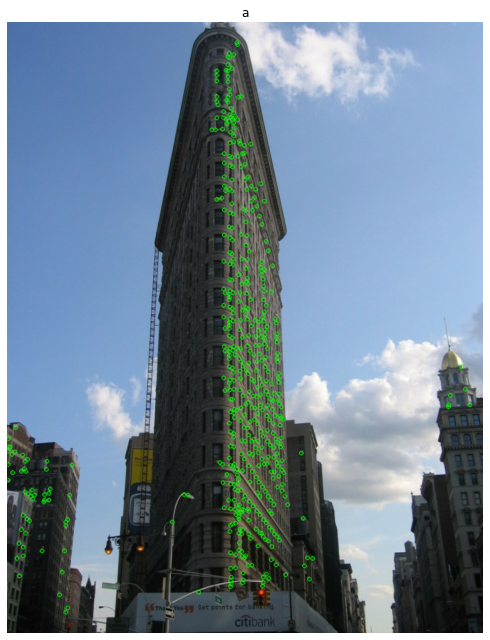

In [26]:
from source.projective.warp import warp_points
from source.models.shi.module import get_shi_score
from source.utils.endpoint_utils import select_kp

sobel_size, window_size, window_cov = 3, 3, 2

shi_score1 = get_shi_score(item[du.IMAGE_GRAY1], sobel_size, window_size, window_cov)
shi_score2 = get_shi_score(item[du.IMAGE_GRAY2], sobel_size, window_size, window_cov)

nms_size = 5
k = 1024

kp1 = select_kp(shi_score1, nms_size, k)
w_kp1, w_kp_mask1 = warp_points(kp1, rbt_data)

plot_figures({'a': draw_cv_keypoints(image1, kp1, draw_mask=w_kp_mask1)}, 1, 1, (16, 9))

In [27]:
from source.utils.endpoint_utils import sample_tensor_patch

patch_size = 9
lpatch_size = 37

ig_patch1 = sample_tensor_patch(image1, kp1, patch_size, image1.shape)
w_ig_patch1 = sample_tensor_patch(image2, w_kp1, patch_size, image2.shape)

ig_lpatch1 = sample_tensor_patch(image1, kp1, lpatch_size, image1.shape)
w_ig_lpatch1 = sample_tensor_patch(image2, w_kp1, lpatch_size, image2.shape)

shi_patch1 = sample_tensor_patch(shi_score1, kp1, patch_size, shi_score1.shape)
w_shi_patch1 = sample_tensor_patch(shi_score2, w_kp1, patch_size, shi_score2.shape)

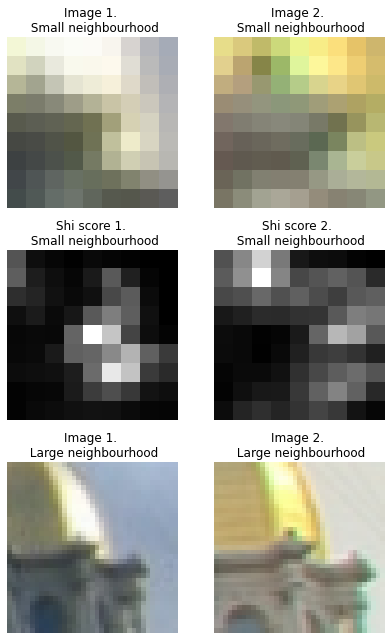

In [28]:
idx = 0

plot_figures({'Image 1. \n Small neighbourhood': torch2cv(ig_patch1[0, w_kp_mask1[0]][idx].permute(1, 0).view(3, patch_size, patch_size)),
              'Image 2. \n Small neighbourhood': torch2cv(w_ig_patch1[0, w_kp_mask1[0]][idx].permute(1, 0).view(3, patch_size, patch_size)),
              'Shi score 1. \n Small neighbourhood': torch2cv(shi_patch1[0, w_kp_mask1[0]][idx].view(1, patch_size, patch_size), normalize=True),
              'Shi score 2. \n Small neighbourhood': torch2cv(w_shi_patch1[0, w_kp_mask1[0]][idx].view(1, patch_size, patch_size), normalize=True),
              'Image 1. \n Large neighbourhood': torch2cv(ig_lpatch1[0, w_kp_mask1[0]][idx].permute(1, 0).view(3, lpatch_size, lpatch_size)),
              'Image 2. \n Large neighbourhood': torch2cv(w_ig_lpatch1[0, w_kp_mask1[0]][idx].permute(1, 0).view(3, lpatch_size, lpatch_size)),},
             3, 2, (6, 9))

## Multiview correspondences

In [29]:
from omegaconf import OmegaConf

from source.datasets.megadepth.transforms import get_megadepth_transforms
from source.datasets.megadepth.dataset import MegaDepthDataset
from torch.utils.data.dataloader import DataLoader

s = """
    csv_path: "/mnt/sda/datasets/MegaDepth/SceneInfo/train_disk.csv"
    data_options:
      - 'image'
      - 'depth'
      - 'calib'

    transforms:
      base: 'train'
      
      grayscale:
      
      resize:      
        width: -1
        height: -1
        
      crop1:
        type: 'divisor_crop'
        
      crop2:
        type: 'depth_crop'
"""

dataset_config = OmegaConf.create(s)

item_transforms = get_megadepth_transforms(dataset_config, 16)
dataset = MegaDepthDataset.from_config(dataset_config, 'f_pydegensac/2k', item_transforms)
loader = DataLoader(dataset, 1)

_iter = loader.__iter__()

In [35]:
import pandas as pd
from source.datasets.base.utils import from_pairs_annotations
from source.models.shi.module import get_shi_score
from source.projective.warp import warp_points
from source.utils.endpoint_utils import select_kp, sample_tensor_patch

pair_csv = pd.read_csv("/mnt/sda/datasets/MegaDepth/SceneInfo/train_disk_pairs.csv", index_col=[0])

sobel_size, window_size, window_cov = 3, 3, 2

nms_size = 5
k = 1024

patch_size = 9
lpatch_size = 37

ig_patch1 = None
ig_lpatch1 = None
shi_patch1 = None

w_ig_patch1 = []
w_ig_lpatch1 = []
w_shi_patch1 = []

w_kp_mask1 = []

for i in _iter:
    scene_name = i[du.IMAGE_NAME1][0].split('/')[1]
    image_name1 = i[du.IMAGE_NAME1][0]
    
    image1, image_gray1 = i[du.IMAGE1], i[du.IMAGE_GRAY1]
    shi_score1 = get_shi_score(image_gray1, sobel_size, window_size, window_cov)
    
    kp1 = select_kp(shi_score1, nms_size, k)
    
    ig_patch1 = sample_tensor_patch(image1, kp1, patch_size, image1.shape)
    ig_lpatch1 = sample_tensor_patch(image1, kp1, lpatch_size, image1.shape)
    shi_patch1 = sample_tensor_patch(shi_score1, kp1, patch_size, shi_score1.shape)
    
    row_pairs = pair_csv.loc[((pair_csv[du.SCENE_NAME] == int(scene_name)) &
                              (pair_csv[du.IMAGE1] == image_name1)) |
                             ((pair_csv[du.SCENE_NAME] == int(scene_name)) &
                              (pair_csv[du.IMAGE2] == image_name1))]
    row_corrs = from_pairs_annotations(row_pairs)
    row_corrs = row_corrs[row_corrs[du.IMAGE1] != image_name1]
    
    corrs_loader = DataLoader(MegaDepthDataset("/mnt/sda/datasets/MegaDepth",
                                               row_corrs, 
                                               [du.IMAGE, du.DEPTH, du.CALIB], 
                                               None,
                                               'f_pydegensac/2k',
                                               item_transforms), 1)
    for j in corrs_loader:
        image2, image_gray2 = j[du.IMAGE1], j[du.IMAGE_GRAY1]
        shi_score2 = get_shi_score(image_gray2, sobel_size, window_size, window_cov)
        
        rbt_data = RBTDataWrapper().init_from_batches(i, j, torch.device('cpu'))
        
        w_kp1, w_kp_mask1j = warp_points(kp1, rbt_data)
        
        w_ig_patch1j = sample_tensor_patch(image2, w_kp1, patch_size, image2.shape)
        w_ig_lpatch1j = sample_tensor_patch(image2, w_kp1, lpatch_size, image2.shape)
        w_shi_patch1j = sample_tensor_patch(shi_score2, w_kp1, patch_size, shi_score2.shape)
        
        w_ig_patch1.append(w_ig_patch1j)
        w_ig_lpatch1.append(w_ig_lpatch1j)
        w_shi_patch1.append(w_shi_patch1j)
        
        w_kp_mask1.append(w_kp_mask1j)
    
    break
    
w_kp_mask1 = torch.cat(w_kp_mask1).prod(0).unsqueeze(0).bool()

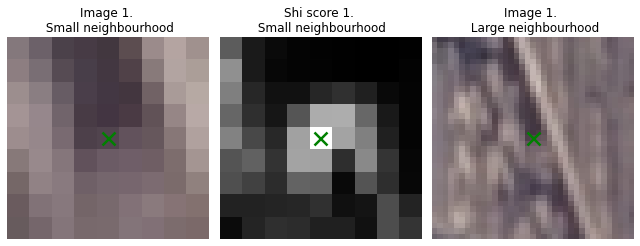

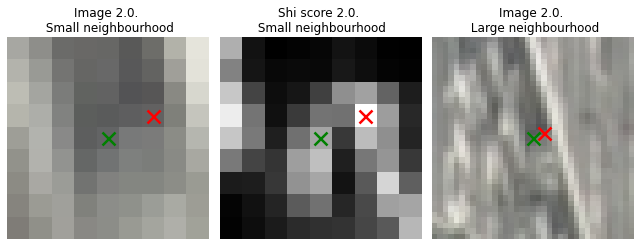

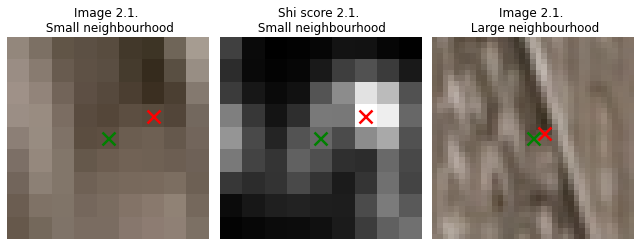

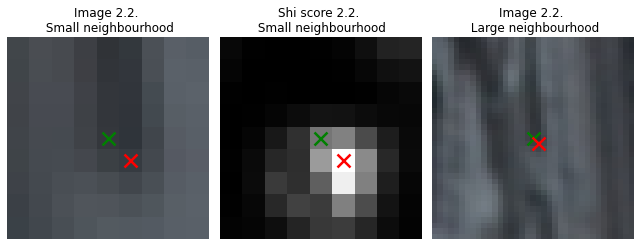

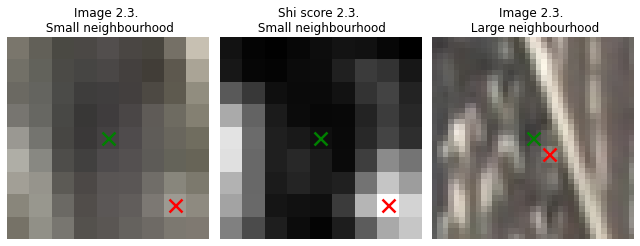

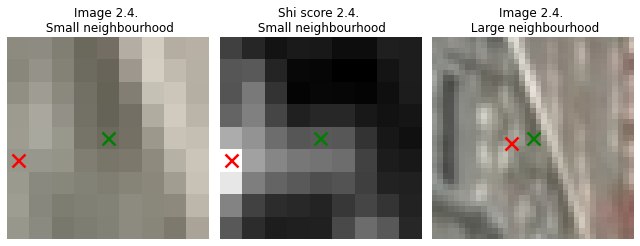

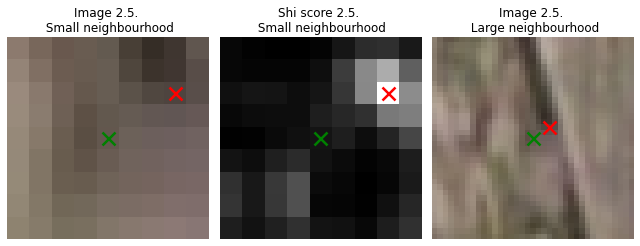

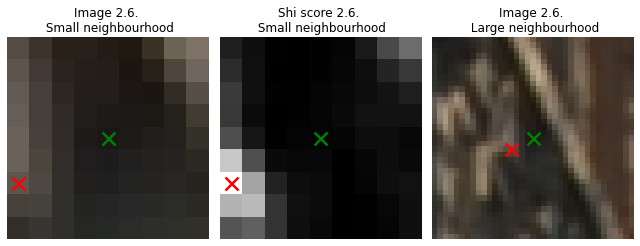

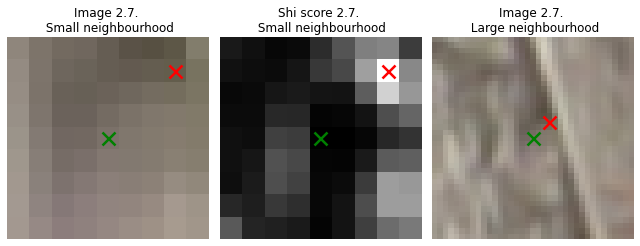

In [36]:
from source.utils.vis_utils import draw_crosshair

idx = 90

_, axes = plot_figures({'Image 1. \n Small neighbourhood': torch2cv(ig_patch1[0, w_kp_mask1[0]][idx].permute(1, 0).view(3, patch_size, patch_size)),
                        'Shi score 1. \n Small neighbourhood': torch2cv(shi_patch1[0, w_kp_mask1[0]][idx].view(1, patch_size, patch_size), normalize=True),
                        'Image 1. \n Large neighbourhood': torch2cv(ig_lpatch1[0, w_kp_mask1[0]][idx].permute(1, 0).view(3, lpatch_size, lpatch_size))},
                       1, 3, (9, 5), return_axes=True)

for ax, ps in zip(axes, [patch_size, patch_size, lpatch_size]):
    draw_crosshair(ax, [ps // 2],  markersize=13, markeredgewidth=2.5)


for corr_idx in range(len(w_ig_patch1)):
    _, axes = plot_figures({f'Image 2.{corr_idx}. \n Small neighbourhood': torch2cv(w_ig_patch1[corr_idx][0, w_kp_mask1[0]][idx].permute(1, 0).view(3, patch_size, patch_size)),
                            f'Shi score 2.{corr_idx}. \n Small neighbourhood': torch2cv(w_shi_patch1[corr_idx][0, w_kp_mask1[0]][idx].view(1, patch_size, patch_size), normalize=True),
                            f'Image 2.{corr_idx}. \n Large neighbourhood': torch2cv(w_ig_lpatch1[corr_idx][0, w_kp_mask1[0]][idx].permute(1, 0).view(3, lpatch_size, lpatch_size))},
                           1, 3, (9, 5), return_axes=True)
    
    max_pt = flat2grid(w_shi_patch1[corr_idx][0, w_kp_mask1[0]][idx].argmax().unsqueeze(0), patch_size).squeeze(0)
    
    for ax, ps in zip(axes, [patch_size, patch_size, lpatch_size]):
        draw_crosshair(ax, [ps // 2], markersize=13, markeredgewidth=2.5)
        
    for ax, pt in zip(axes, [max_pt, max_pt, max_pt + (lpatch_size - patch_size) // 2]):
        draw_crosshair(ax, pt, color='red', markersize=13, markeredgewidth=2.5)
    